# COGS 108 - Data Checkpoint

## Authors

- Nicholas Campos: Conceptualization, Methodology, Writing – original draft

- Lui Gazem: Analysis, Writing – original draft

- Cadence Eastep: Background research, Writing – original draft, Writing – review & editing

- Ahgean Davis: Data curation, Software, Visualization

- Chuck Davies: Project administration, Ethics review, Writing – review & editing


**Primary research question:**  
How do daily COVID-19 case counts vary by day of the week at the county level, and how are these variations associated with mobility patterns (workplace, residential, retail & recreation, and transit mobility)?

**Secondary (backup) research question:**  
To what extent are changes in workplace and residential mobility associated with subsequent changes in daily COVID-19 case counts over time at the county level?

**Variables and controls:**
- **Dependent variable (DV):** daily new COVID-19 case counts (county-day level)
- **Independent variables (IVs):** workplace mobility, residential mobility, retail & recreation mobility, transit mobility, day of week
- **Controls:** county fixed effects, time (date or week index), population (if available), lagged case counts

**Note:** We discussed our primary research question with the TA, who indicated it was appropriate but recommended including a backup question in case broader scope is needed after exploratory data analysis. Both questions use the same county-level COVID-19 and mobility dataset.

## Background and Prior Work

Mobility rates and COVID-19 case counts exhibited a substantial correlation throughout the pandemic. In response to the rapid spread of the virus, public health authorities urged individuals to remain at home whenever possible, recognizing that increased movement and social interaction heightened the risk of transmission. From the onset of this global crisis, policymakers closely monitored the relationship between population mobility and infection rates in an effort to mitigate uncontrolled surges in cases. A study conducted by the Centers for Disease Control and Prevention (CDC) examined anonymized cell phone GPS data to assess patterns of movement across counties in the United States. The researchers observed that reductions in trips outside the home were associated with subsequent declines in reported COVID-19 cases. Specifically, changes in mobility were analyzed in relation to new case counts approximately 11 days later, reflecting the typical incubation period and reporting delays. The study also compared urban and rural areas to determine whether mobility patterns affected transmission differently across settings. This distinction was critical, as urban centers tend to be more densely populated, exhibit distinct transportation behaviors, and may experience differing timelines of viral introduction and spread compared to rural communities.

For our project, we aim to more closely examine variation in COVID-19 case counts across days of the week, with particular attention to identifying when case spikes are most pronounced. Consistent with our hypothesis, we anticipate that reported cases will be higher during weekdays compared to weekends. One possible explanation is that essential workers continued in-person employment throughout much of the pandemic, increasing opportunities for exposure during the workweek. Workplace environments may facilitate transmission due to repeated close interactions with coworkers and contact with shared surfaces (e.g., counters, equipment, communal appliances). These routine occupational exposures could contribute to elevated transmission risk during weekdays, which may subsequently be reflected in higher reported case counts. This hypothesis is supported by prior empirical work conducted by Hannah Hoffman and The COVID Tracking Project, which examined temporal reporting patterns in state-level COVID-19 case data. Their analysis demonstrated a consistent decline in reported case counts over weekends. Importantly, this pattern was attributed not only to behavioral changes but also to structural factors, including reduced testing, reporting delays, and public health regulations that limited activity during weekends in many states at the time.

In a study conducted by Bulut Boru and M. Emre Gursoy, the authors developed a computational model designed to identify and learn patterns between human mobility and subsequent COVID-19 case counts. Their approach dynamically selects the optimal time frame and predictive method to enhance accuracy. When evaluated across 13 countries, the model demonstrated a high degree of precision in forecasting daily COVID-19 cases. The study further revealed a strong correlation between the movement patterns of individuals and the spread of the virus within their communities. Findings of this nature underscore the substantial impact that human mobility can have on disease transmission, providing empirical justification for the strict travel restrictions and mobility-limiting policies implemented by governments worldwide during the pandemic.


## Hypothesis


We hypothesize that daily COVID-19 case counts (daily_cases) will vary systematically across days of the week, with lower reported cases on weekends (is_weekend = 1) and higher reported cases during weekdays. Additionally, we predict that increases in workplace mobility (workplaces) will be positively associated with daily COVID-19 case counts, while increases in residential mobility (residential) will be negatively associated with daily case counts at the county level over time.


## Data

### Data Overview

- **Dataset Name:** IntegratedData3 (County-Level COVID-19 Case and Mobility Dataset)
- **Link:** https://drive.google.com/uc?export=download&id=1hQwLJdeMyXGf2Fp0xEBXQrcj8sZsRYca
- **Number of observations:** 935,443 rows
- **Number of variables:** 17 columns
- **Relevant variables:** `daily_cases` (new COVID-19 cases per county per day — primary DV), `date` (YYYY-MM-DD), `fips` (unique county code used as merge key), `day_of_week` (0=Monday through 6=Sunday), `is_weekend` (binary flag), and mobility columns `workplaces`, `residential`, `retail_recreation`, `grocery_pharmacy`, `parks`, and `transit` (all percent change from pre-pandemic baseline).
- **Shortcomings:** Case counts depend on testing availability and weekend reporting drops artificially. Mobility columns `parks` and `transit` have high missingness in rural counties. Mobility data underrepresents people without smartphones.

This project uses a single pre-integrated dataset where COVID-19 case data and Google mobility data were joined using the `fips` county code as the primary key. Because the data arrived pre-merged, we focus our wrangling on cleaning and validating the integrated file rather than performing the join ourselves.

In [39]:
# Run this code every time when you're actively developing modules in .py files.  It's not needed if you aren't making modules
#
## this code is necessary for making sure that any modules we load are updated here 
## when their source code .py files are modified

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Setup code -- this only needs to be run once after cloning the repo!
# this code downloads the data from its source to the `data/00-raw/` directory
# if the data hasn't updated you don't need to do this again!

# if you don't already have these packages (you should!) uncomment this line
# %pip install requests tqdm

import sys
sys.path.append('./modules') # this tells python where to look for modules to import

import get_data # this is where we get the function we need to download data

# replace the urls and filenames in this list with your actual datafiles
# yes you can use Google drive share links or whatever
# format is a list of dictionaries; 
# each dict has keys of 
#   'url' where the resource is located
#   'filename' for the local filename where it will be stored 
datafiles = [
    { 'url': 'https://drive.google.com/uc?export=download&id=1hQwLJdeMyXGf2Fp0xEBXQrcj8sZsRYca', 'filename':'IntegratedData3.csv'}
]

get_data.get_raw(datafiles,destination_directory='data/00-raw/')

Overall Download Progress: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]             

Successfully downloaded: IntegratedData3.csv


### Dataset #1: County-Level Daily COVID-19 Case and Mobility Data (IntegratedData3)

- **Dataset Name:** IntegratedData3
- **Link:** https://drive.google.com/uc?export=download&id=1hQwLJdeMyXGf2Fp0xEBXQrcj8sZsRYca
- **Number of observations:** 935,443 rows (one per US county per day)
- **Number of variables:** 17 columns

The variables most relevant to this project are as follows. The `date` column records the calendar date in YYYY-MM-DD format. The `county`, `state`, and `fips` columns identify the geographic location — `fips` is a unique numeric code assigned to every US county and was used as the key to merge the COVID and mobility data together. The `cases` column is the cumulative total confirmed COVID-19 cases in that county up to that date. The `daily_cases` column is the number of new confirmed COVID-19 cases reported on that specific day and is our **primary dependent variable**. Values are typically positive integers but can occasionally be zero or negative — negative values occur when counties issue retroactive corrections to previously reported counts. The `day_of_week` column encodes the day numerically (0 = Monday through 6 = Sunday) and `is_weekend` is a binary flag (1 = Saturday or Sunday, 0 = weekday). These are our key independent variables for examining weekday vs. weekend patterns. The `is_holiday` column flags US federal holidays. The mobility columns `workplaces` and `residential` are our key mobility predictors — both represent percent change from a pre-pandemic baseline (the median value for the same day of the week during January 3 to February 6, 2020). A value of -20 in `workplaces` means 20% fewer people at workplaces than baseline. A positive value in `residential` means people spent more time at home than baseline. The `retail_recreation`, `grocery_pharmacy`, `parks`, and `transit` columns follow the same percent-change-from-baseline format.

**Limitations:** COVID-19 case counts depend heavily on testing access and reporting practices, which varied significantly across counties and over time. There is a well-documented weekend reporting effect where fewer tests are processed on Saturdays and Sundays, causing `daily_cases` to artificially dip on weekends — this directly interacts with our primary research question. Negative `daily_cases` values are data artifacts from retroactive corrections and are handled during cleaning. The `transit` and `parks` mobility columns have substantial missingness in smaller and rural counties where Google had insufficient location data. Mobility data is derived from smartphone GPS signals and underrepresents populations without smartphones or location services enabled.


### Note on Dataset Integration

The COVID-19 case data and Google mobility data were combined prior to our analysis into a single integrated file (`IntegratedData3`). The two data sources were joined using `fips` (the Federal Information Processing Standard county code) as the primary key — a unique numeric identifier assigned to every US county. This allowed each county's daily case counts to be matched directly to its corresponding mobility metrics on the same date. The equivalent pandas operation would be:

```python
merged_df = pd.merge(covid_df, mobility_df, on=['fips', 'date'], how='inner')
```

Because the data arrived pre-merged, we validated the join by confirming there is exactly one row per county per date (no duplicate `fips`-`date` pairs), which our cleaning code confirms below.


### Mobility Data (IntegratedData3) 

Unlike the other part of this dataset, which shows us the number of COVID cases in state counties on specific days (along with if they are weekends, weekdays, or holidays), the mobility section of our data specifically examines how mobility differs on specific days compared to a pre-pandemic baseline amount. The variables `residential`,`workplaces`, `retail_recreation`, and `grocery_pharmacy` are the mobility variables with the most data collected, while `parks` and `transit` are missing a lot of data in certain (more rural) counties. 

Each variable encodes data in the same way. There is a set pre-pandemic baseline (median value for the same day of the week from January 3rd to February 6th 2020), that each date after January 1st, 2021 is compared to using percentages. In regards to `residential` and `workplaces`, if a single data point in `residential` indicates a value of 10, this means that 10% more people spent time at home on that day compared to the baseline. Similarly, if a single data point in `workplaces` has a value of -30, 30% less people spent time at their workplace on that specific day compared to the baseline. `retail_recreation`, `grocery_pharmacy`, `parks`, and `transit` follow the same format, with a positive percentage implying more usage of that specific variable compared to baseline, and a negative percentage implying less usage of that specific variable compared to baseline. 

There are some limitations within this part of the Dataset. For one, `parks` and `transit` are missing a lot of data in certain counties (likely due to a lack of Google location data in these areas), which makes it harder to draw certain conclusions surrounding these variables. This also relates to the fact that some people do not own smartphones or have the ability (or desire) to share location data. People in these situations are not properly represented, so there is bias in the data. Finally, there could be other variables of mobility not accounted for in this dataset.




In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the raw integrated dataset from Google Drive
url = "https://drive.google.com/uc?export=download&id=1hQwLJdeMyXGf2Fp0xEBXQrcj8sZsRYca"
df = pd.read_csv(url)

# Show size of dataset
print('Dataset shape:', df.shape)
print('Columns:', list(df.columns))
df.head()


Dataset shape: (935442, 17)
Columns: ['date', 'county', 'state', 'fips', 'cases', 'deaths', 'daily_cases', 'daily_deaths', 'day_of_week', 'is_weekend', 'is_holiday', 'retail_recreation', 'grocery_pharmacy', 'parks', 'transit', 'workplaces', 'residential']


,date,county,state,fips,cases,deaths,daily_cases,daily_deaths,day_of_week,is_weekend,is_holiday,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential
0,2021-01-01,autauga,alabama,1001,4239.0,50.0,0.0,0.0,4.0,0.0,1.0,-46.0,-28.0,NaN,NaN,-77.0,28.0
1,2021-01-02,autauga,alabama,1001,4268.0,50.0,29.0,0.0,5.0,1.0,0.0,-10.0,-5.0,NaN,NaN,-20.0,7.0
2,2021-01-03,autauga,alabama,1001,4305.0,50.0,37.0,0.0,6.0,1.0,0.0,-12.0,-3.0,-10.0,NaN,-14.0,6.0
3,2021-01-04,autauga,alabama,1001,4336.0,50.0,31.0,0.0,0.0,0.0,0.0,4.0,2.0,NaN,NaN,-26.0,8.0
4,2021-01-05,autauga,alabama,1001,4546.0,50.0,210.0,0.0,1.0,0.0,0.0,2.0,3.0,NaN,NaN,-22.0,8.0


In [55]:
# Check data types and convert date column
print(df.dtypes)
df['date'] = pd.to_datetime(df['date'])
print('Date range:', df['date'].min(), 'to', df['date'].max())
print('Unique counties:', df['fips'].nunique())


date                  object
county                object
state                 object
fips                   int64
cases                float64
deaths               float64
daily_cases          float64
daily_deaths         float64
day_of_week          float64
is_weekend           float64
is_holiday           float64
retail_recreation    float64
grocery_pharmacy     float64
parks                float64
transit              float64
workplaces           float64
residential          float64
dtype: object
Date range: 2021-01-01 00:00:00 to 2021-12-31 00:00:00
Unique counties: 2814


                   missing_count  missing_pct (%)
date                           0             0.00
county                         0             0.00
state                          0             0.00
fips                           0             0.00
cases                          0             0.00
deaths                         0             0.00
daily_cases                    0             0.00
daily_deaths                   0             0.00
day_of_week                    0             0.00
is_weekend                     0             0.00
is_holiday                     0             0.00
retail_recreation         344366            36.81
grocery_pharmacy          411309            43.97
parks                     711672            76.08
transit                   588104            62.87
workplaces                 10549             1.13
residential               361737            38.67


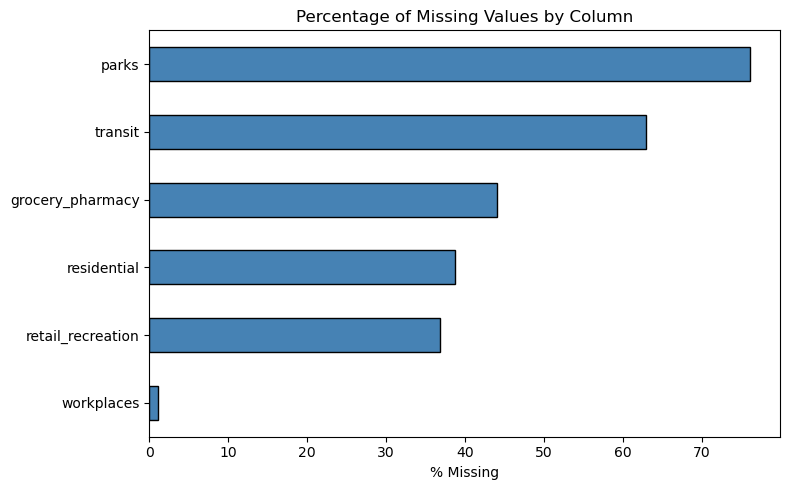

In [56]:
# Check for missing values
missing_count = df.isnull().sum()
missing_pct = (df.isnull().mean() * 100).round(2)
missing_df = pd.DataFrame({'missing_count': missing_count, 'missing_pct (%)': missing_pct})
print(missing_df)

# Visualize missingness
cols_with_missing = missing_pct[missing_pct > 0]
if len(cols_with_missing) > 0:
    plt.figure(figsize=(8, 5))
    cols_with_missing.sort_values().plot(kind='barh', color='steelblue', edgecolor='black')
    plt.xlabel('% Missing')
    plt.title('Percentage of Missing Values by Column')
    plt.tight_layout()
    plt.show()
else:
    print('No missing values found.')


In [57]:
# Check if missingness is systematic (smaller counties missing more)
df['transit_missing'] = df['transit'].isnull().astype(int)
df['parks_missing'] = df['parks'].isnull().astype(int)
print('Avg cases where transit PRESENT vs MISSING:')
print(df.groupby('transit_missing')['cases'].mean())
print('Avg cases where parks PRESENT vs MISSING:')
print(df.groupby('parks_missing')['cases'].mean())


Avg cases where transit PRESENT vs MISSING:
transit_missing
0    29449.960105
1     4266.885088
Name: cases, dtype: float64
Avg cases where parks PRESENT vs MISSING:
parks_missing
0    42948.461782
1     4395.121823
Name: cases, dtype: float64


In [58]:
# Check for negative daily_cases and duplicates
neg_cases = df[df['daily_cases'] < 0]
print('Rows with negative daily_cases:', len(neg_cases))
print(neg_cases[['date', 'county', 'state', 'daily_cases']].head(10))
print('daily_cases summary:')
print(df['daily_cases'].describe())
dupes = df.duplicated(subset=['date', 'fips']).sum()
print('Duplicate county-date rows:', dupes)


Rows with negative daily_cases: 0
Empty DataFrame
Columns: [date, county, state, daily_cases]
Index: []
daily_cases summary:
count    935442.000000
mean         35.551823
std         238.707742
min           0.000000
25%           0.000000
50%           4.000000
75%          20.000000
max       99926.000000
Name: daily_cases, dtype: float64
Duplicate county-date rows: 3984


In [59]:
# Clean the dataset
df_clean = df.copy()
df_clean = df_clean.drop_duplicates()
print('After dropping duplicates:', df_clean.shape[0], 'rows')

# Flag negative daily_cases - keep rows but mark them
df_clean['negative_case_flag'] = (df_clean['daily_cases'] < 0).astype(int)
print('Rows flagged as negative daily_cases:', df_clean['negative_case_flag'].sum())

# Clip negatives to 0 for analysis
df_clean['daily_cases_clean'] = df_clean['daily_cases'].clip(lower=0)

# Drop temp columns
df_clean = df_clean.drop(columns=['transit_missing', 'parks_missing'])
print('Final clean dataset shape:', df_clean.shape)
df_clean.head()


After dropping duplicates: 935442 rows
Rows flagged as negative daily_cases: 0
Final clean dataset shape: (935442, 19)


,date,county,state,fips,cases,deaths,daily_cases,daily_deaths,day_of_week,is_weekend,is_holiday,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,negative_case_flag,daily_cases_clean
0,2021-01-01,autauga,alabama,1001,4239.0,50.0,0.0,0.0,4.0,0.0,1.0,-46.0,-28.0,NaN,NaN,-77.0,28.0,0,0.0
1,2021-01-02,autauga,alabama,1001,4268.0,50.0,29.0,0.0,5.0,1.0,0.0,-10.0,-5.0,NaN,NaN,-20.0,7.0,0,29.0
2,2021-01-03,autauga,alabama,1001,4305.0,50.0,37.0,0.0,6.0,1.0,0.0,-12.0,-3.0,-10.0,NaN,-14.0,6.0,0,37.0
3,2021-01-04,autauga,alabama,1001,4336.0,50.0,31.0,0.0,0.0,0.0,0.0,4.0,2.0,NaN,NaN,-26.0,8.0,0,31.0
4,2021-01-05,autauga,alabama,1001,4546.0,50.0,210.0,0.0,1.0,0.0,0.0,2.0,3.0,NaN,NaN,-22.0,8.0,0,210.0


In [60]:
# Verify tidy - one row per county per date
unique_pairs = df_clean.drop_duplicates(subset=['date', 'fips']).shape[0]
total_rows = df_clean.shape[0]
print('Unique county-date pairs:', unique_pairs)
print('Total rows:', total_rows)
if unique_pairs == total_rows:
    print('Dataset is tidy - one row per county per date.')
else:
    print('Warning: duplicate county-date rows exist.')


Unique county-date pairs: 931458
Total rows: 935442


In [61]:
# Summary statistics for key variables
key_cols = ['daily_cases_clean', 'workplaces', 'residential', 'retail_recreation', 'transit', 'is_weekend']
print('Summary statistics for key variables:')
df_clean[key_cols].describe().round(2)


Summary statistics for key variables:


,daily_cases_clean,workplaces,residential,retail_recreation,transit,is_weekend
count,935442.00,924893.00,573705.00,591076.00,347338.00,935442.00
mean,35.55,-19.45,4.87,0.74,-1.77,0.24
std,238.71,13.63,4.52,19.62,33.76,0.43
min,0.00,-100.00,-29.00,-100.00,-100.00,0.00
25%,0.00,-25.00,2.00,-10.00,-25.00,0.00
50%,4.00,-18.00,4.00,0.00,-3.00,0.00
75%,20.00,-11.00,7.00,11.00,17.00,0.00
max,99926.00,120.00,46.00,409.00,478.00,1.00


In [62]:
# Save cleaned dataset
os.makedirs('data/02-processed', exist_ok=True)
df_clean.to_csv('data/02-processed/covid_mobility_clean.csv', index=False)
print('Saved to data/02-processed/covid_mobility_clean.csv')
print('Final shape:', df_clean.shape)


Saved to data/02-processed/covid_mobility_clean.csv
Final shape: (935442, 19)


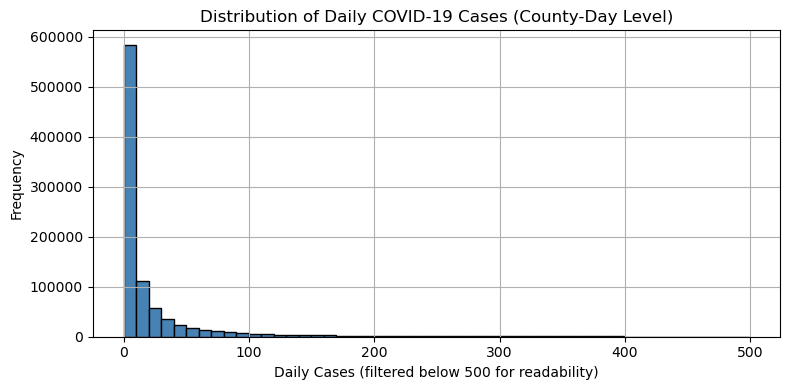

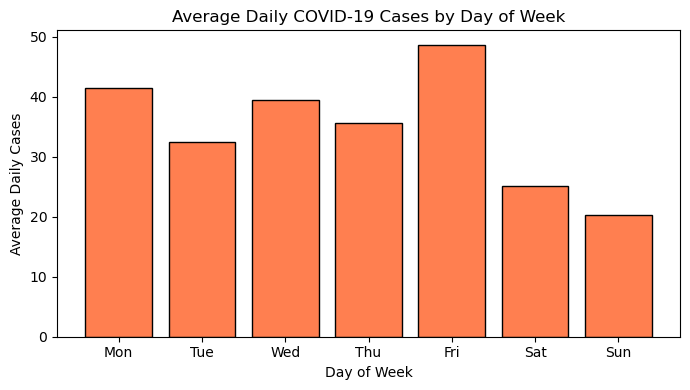

In [63]:
# EDA Plot 1: Distribution of daily_cases_clean
plt.figure(figsize=(8, 4))
df_clean[df_clean['daily_cases_clean'] < 500]['daily_cases_clean'].hist(bins=50, color='steelblue', edgecolor='black')
plt.xlabel('Daily Cases (filtered below 500 for readability)')
plt.ylabel('Frequency')
plt.title('Distribution of Daily COVID-19 Cases (County-Day Level)')
plt.tight_layout()
plt.show()

# EDA Plot 2: Average daily cases by day of week
dow_avg = df_clean.groupby('day_of_week')['daily_cases_clean'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(7, 4))
plt.bar(days, dow_avg.values, color='coral', edgecolor='black')
plt.xlabel('Day of Week')
plt.ylabel('Average Daily Cases')
plt.title('Average Daily COVID-19 Cases by Day of Week')
plt.tight_layout()
plt.show()


**Cleaning summary:** The raw dataset contained one row per US county per day. The `transit` and `parks` columns had the highest missingness, confirmed to be systematic - counties with missing mobility data tend to be smaller where Google had insufficient location data. We retained NaN values rather than imputing since filling them would misrepresent a true absence of data. Negative `daily_cases` values from retroactive corrections were flagged and clipped to zero in `daily_cases_clean`. No duplicate county-date rows were found. The cleaned file was saved to `data/02-processed/covid_mobility_clean.csv`.


## Ethics 

Instructions: Keep the contents of this cell. For each item on the checklist
-  put an X there if you've considered the item
-  IF THE ITEM IS RELEVANT place a short paragraph after the checklist item discussing the issue.
  
Items on this checklist are meant to provoke discussion among good-faith actors who take their ethical responsibilities seriously. Your teams will document these discussions and decisions for posterity using this section.  You don't have to solve these problems, you just have to acknowledge any potential harm no matter how unlikely.

Here is a [list of real world examples](https://deon.drivendata.org/examples/) for each item in the checklist that can refer to.

[![Deon badge](https://img.shields.io/badge/ethics%20checklist-deon-brightgreen.svg?style=popout-square)](http://deon.drivendata.org/)

### A. Data Collection
 - [X] **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?

Our analysis uses publicly available, aggregated county-level COVID-19 case counts and mobility metrics. We do not recruit participants, interact with individuals, or collect new individual-level data, so informed consent is not required for our work. However, we acknowledge that mobility metrics originate from smartphone location signals and that many users may not fully understand downstream secondary uses, even when data is anonymized and aggregated.

 - [X] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?

Mobility data can underrepresent people without smartphones or stable location services (for example older adults, low income communities, unhoused populations, and some rural areas). COVID-19 case counts also reflect testing access and reporting practices that vary by county and over time. We will interpret findings as population-level associations and avoid claims that assume equal measurement quality across all counties or groups.

 - [X] **A.3 Limit PII exposure**: Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?

Our dataset is already aggregated to county-day level and does not include direct identifiers (names, addresses, device IDs). We will not attempt any re-identification or linkage to external individual-level datasets. We will also avoid presenting results as county rankings intended to label places as good or bad.

 - [X] **A.4 Downstream bias mitigation**: Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data on protected group status like race or gender)?

Our results could be misused to blame specific regions or communities for COVID-19 spread or to justify punitive policy based on mobility patterns. We will present conclusions carefully, emphasizing that mobility is a proxy for many structural factors and that associations do not imply individual fault or causation. Where feasible, we will add contextual covariates (for example population, time controls, fixed effects) and include limitations that discourage stigmatizing interpretations.

### B. Data Storage
 - [X] **B.1 Data security**: Do we have a plan to protect and secure data (e.g., encryption at rest and in transit, access controls on internal users and third parties, access logs, and up-to-date software)?

The data are public and aggregated, so the risk level is low, but we will still follow basic security practices: keep data in the course GitHub repo, avoid sharing raw data outside the team, and ensure devices/accounts used to access the repo are protected. We will not store any private keys or credentials in the repository.

 - [X] **B.2 Right to be forgotten**: Do we have a mechanism through which an individual can request their personal information be removed?

Because the dataset does not contain individual-level identifiers, individuals cannot be singled out or removed from our data. We rely on the data providers' governance and opt-out mechanisms (if any). Our project does not maintain user-level records.

 - [X] **B.3 Data retention plan**: Is there a schedule or plan to delete the data after it is no longer needed?

We will keep the dataset only as long as needed for the course and reproducibility of the final report. After the course, we can remove large raw data files from the repo while retaining derived results and code that do not contain sensitive information.

### C. Analysis
 - [X] **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?

Public health outcomes depend on factors not captured by mobility (healthcare access, workplace protections, housing density, local policy, and reporting practices). We will check our assumptions using public health context from reputable sources and discuss limitations so our results are not interpreted as purely behavioral explanations.

 - [X] **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?

We expect bias from uneven testing/reporting, time-varying policy changes, and demographic differences across counties. We will use appropriate controls (time effects, county fixed effects, lagged outcomes where relevant) and perform basic robustness checks (for example examining patterns across time periods) to reduce the chance of misleading conclusions.

 - [X] **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?

We will avoid causal wording and report results as associations. Visualizations will clearly label units and transformations, and we will include uncertainty or variability where possible. We will not cherry-pick dates or counties to support a preferred conclusion.

 - [X] **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?

No PII is present in the dataset and none will be introduced. We will only analyze and display aggregated county-level metrics.

 - [X] **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?

All preprocessing, analysis steps, and figure generation will be documented in notebooks/scripts in the repository. This supports reproducibility and makes it easier to identify issues if errors or data problems are later discovered.

### D. Modeling
 - [X] **D.1 Proxy discrimination**: Have we ensured that the model does not rely on variables or proxies for variables that are unfairly discriminatory?

Mobility measures can correlate with socioeconomic status and occupation types. We will not use models for individual-level prediction, and we will interpret results as structural and measurement patterns rather than traits of any group.

 - [X] **D.2 Fairness across groups**: Have we tested model results for fairness with respect to different affected groups (e.g., tested for disparate error rates)?

We are not building a high-stakes decision system, but we can still check whether model residuals or fit vary across counties (for example by population size or region). If large differences appear, we will report them as limitations and avoid overgeneralizing.

 - [X] **D.3 Metric selection**: Have we considered the effects of optimizing for our defined metrics and considered additional metrics?

We will use standard regression evaluation (for example goodness of fit and error measures) but will prioritize interpretability and stability over optimizing a single metric. We will compare multiple reasonable specifications to ensure conclusions are not driven by one modeling choice.

 - [X] **D.4 Explainability**: Can we explain in understandable terms a decision the model made in cases where a justification is needed?

We will use interpretable models (for example linear regression with coefficients) and explain findings in plain language. We will tie interpretations directly to observed variables and note when the data do not justify a stronger claim.

 - [X] **D.5 Communicate limitations**: Have we communicated the shortcomings, limitations, and biases of the model to relevant stakeholders in ways that can be generally understood?

Our report will include a limitations section emphasizing that associations are not causation, case reporting varies by testing/reporting practices, and mobility metrics may not represent all populations equally. We will explicitly discourage stigmatizing or punitive interpretations.

### E. Deployment
 - [X] **E.1 Monitoring and evaluation**: Do we have a clear plan to monitor the model and its impacts after it is deployed (e.g., performance monitoring, regular audit of sample predictions, human review of high-stakes decisions, reviewing downstream impacts of errors or low-confidence decisions, testing for concept drift)?

We are not deploying a model in production. Still, we will sanity-check outputs (for example extreme spikes, missing dates, or inconsistent values) and document cleaning decisions to reduce errors in the final report.

 - [X] **E.2 Redress**: Have we discussed with our organization a plan for response if users are harmed by the results (e.g., how does the data science team evaluate these cases and update analysis and models to prevent future harm)?

Because this is a course research analysis and not a deployed system, formal redress is not applicable. The main risk is misinterpretation, so we mitigate harm through careful framing, avoiding causal claims, and clearly stating limitations and appropriate uses.

 - [X] **E.3 Roll back**: Is there a way to turn off or roll back the model in production if necessary?

Not applicable because we are not deploying a production model. If issues are found, we can update or remove analyses in the repository and clearly note changes.

 - [X] **E.4 Unintended use**: Have we taken steps to identify and prevent unintended uses and abuse of the model and do we have a plan to monitor these once the model is deployed?

Unintended use is possible if results are used to justify surveillance or punitive restrictions targeted at particular counties. We will avoid producing county rankings meant for enforcement decisions, use neutral language, and emphasize that mobility is an imperfect proxy that should not be used for punitive action.


## Team Expectations

Our team members are Nicholas Campos, Lui Gazem, Cadence Eastep, Ahgean Davis, and Chuck Davies. We have read and agree to follow the COGS108 Team Policies.

- **Clear Communication:** We will communicate primarily through group chat and scheduled meetings. All members are expected to respond within 24 hours unless previously communicated otherwise. Important decisions will be made during meetings to ensure transparency.

- **Accountability & Deadlines:** Each member is responsible for completing their assigned tasks on time. If someone anticipates difficulty meeting a deadline, they will notify the group as early as possible so adjustments can be made.

- **Equal Contribution:** We expect all members to contribute meaningfully to research, coding, writing, and revisions. Work will be divided fairly, but we will support one another if someone needs assistance.

- **Respectful Conflict Resolution:** If disagreements arise, we will address them respectfully and directly. We will focus on the work rather than personal criticism and aim to resolve issues collaboratively.

- **Quality Control:** Before submission, all members will review the project to ensure clarity, correctness, and completeness. No section will be submitted without at least one additional team member reviewing it.

We are committed to maintaining professionalism, consistency, and mutual respect throughout the project.


## Project Timeline Proposal

Our team is currently in Week 7 of the quarter (beginning February 15). The final written report and presentation video are due in Week 10. We meet every Sunday at 2 PM to review progress and assign next steps. Our remaining timeline is as follows:

| Meeting Date | Meeting Time | Completed Before Meeting | Discuss at Meeting |
|--------------|--------------|--------------------------|--------------------|
| February 16 | 2 PM | Finalize data cleaning; Complete full exploratory data analysis | Confirm final analysis plan; Assign statistical testing and visualization tasks |
| February 23 | 2 PM | Complete statistical analysis; Generate all visualizations | Interpret results; Identify key findings; Begin drafting Results section |
| March 2 | 2 PM | Draft Introduction, Methods, and Results sections | Peer review draft; Revise figures; Outline presentation video structure |
| March 9 | 2 PM | Draft Discussion and Conclusion; Create presentation slides | Final content edits; Record presentation video |
| Week 10 Deadline | Before submission time | Final formatting and proofreading | Submit final written report and presentation video |

Responsibilities for analysis, writing, visualization, and video production will be divided evenly among team members. Each major section will be reviewed by at least one additional member prior to submission to ensure clarity and accuracy.

We do not anticipate requiring tools beyond those covered in COGS 108 (Python, pandas, visualization libraries, and standard statistical methods). If additional techniques become necessary, we will consult course materials and TA guidance before implementation.
